In [1]:
# 1. 패키지 및 라이브러리

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings
%matplotlib inline

import matplotlib.font_manager as fm
font_name = fm.FontProperties(fname = 'C:/Windows/Fonts/malgun.ttf').get_name()
mpl.rc('font', family = font_name)

plt.style.use('seaborn') # seaborn 스타일로 변환
plt.rc('font',family='Malgun Gothic')
plt.rc('axes',unicode_minus=False)
pd.set_option('display.max_columns',None)
warnings.filterwarnings(action='ignore') # Warning Message 안 보이게
import pandas.util.testing as tm

import matplotlib as mpl # 고해상도 Plot 을 위해 DPI 조절
mpl.rcParams['figure.dpi']=150



In [2]:
# 2. 데이터 로드
import pandas as pd

bc = pd.read_csv('C:\\Users\\sjjung\\Desktop\\contestData\\bccard.csv')
bc


,기준년월,품목대분류코드,품목대분류명,품목중분류코드,품목중분류명,성별,연령,가구생애주기,고객소재지_광역시도,고객소재지_시군구,고객소재지_읍면동,매출금액,매출건수
0,201903,10,의류,1010,여성의류,여성,40대,초중고자녀가구,서울특별시,구로구,궁동,782521,13
1,201903,21,e상품/서비스,2110,o2o서비스,여성,20대,신혼영유아가구,서울특별시,구로구,궁동,963789,29
2,201903,19,출산/육아,1913,육아용품서비스,여성,30대,신혼영유아가구,서울특별시,구로구,궁동,924309,46
3,201903,21,e상품/서비스,2111,e머니/상품권,여성,30대,신혼영유아가구,서울특별시,구로구,궁동,1089360,54
4,201903,17,생활,1710,생활용품,여성,30대,신혼영유아가구,서울특별시,구로구,궁동,1656740,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...
519292,202103,20,여가/스포츠,2013,여행,여성,30대,1인가구,서울특별시,영등포구,영등포동7가,1411368,7
519293,202103,21,e상품/서비스,2110,o2o서비스,남성,30대,1인가구,서울특별시,영등포구,영등포동7가,1386040,63
519294,202103,11,패션잡화,1113,시계/주얼리,여성,30대,신혼영유아가구,서울특별시,영등포구,영등포동7가,390818,7
519295,202103,16,식품,1610,가공식품,남성,40대,초중고자녀가구,서울특별시,영등포구,영등포동7가,327592,7


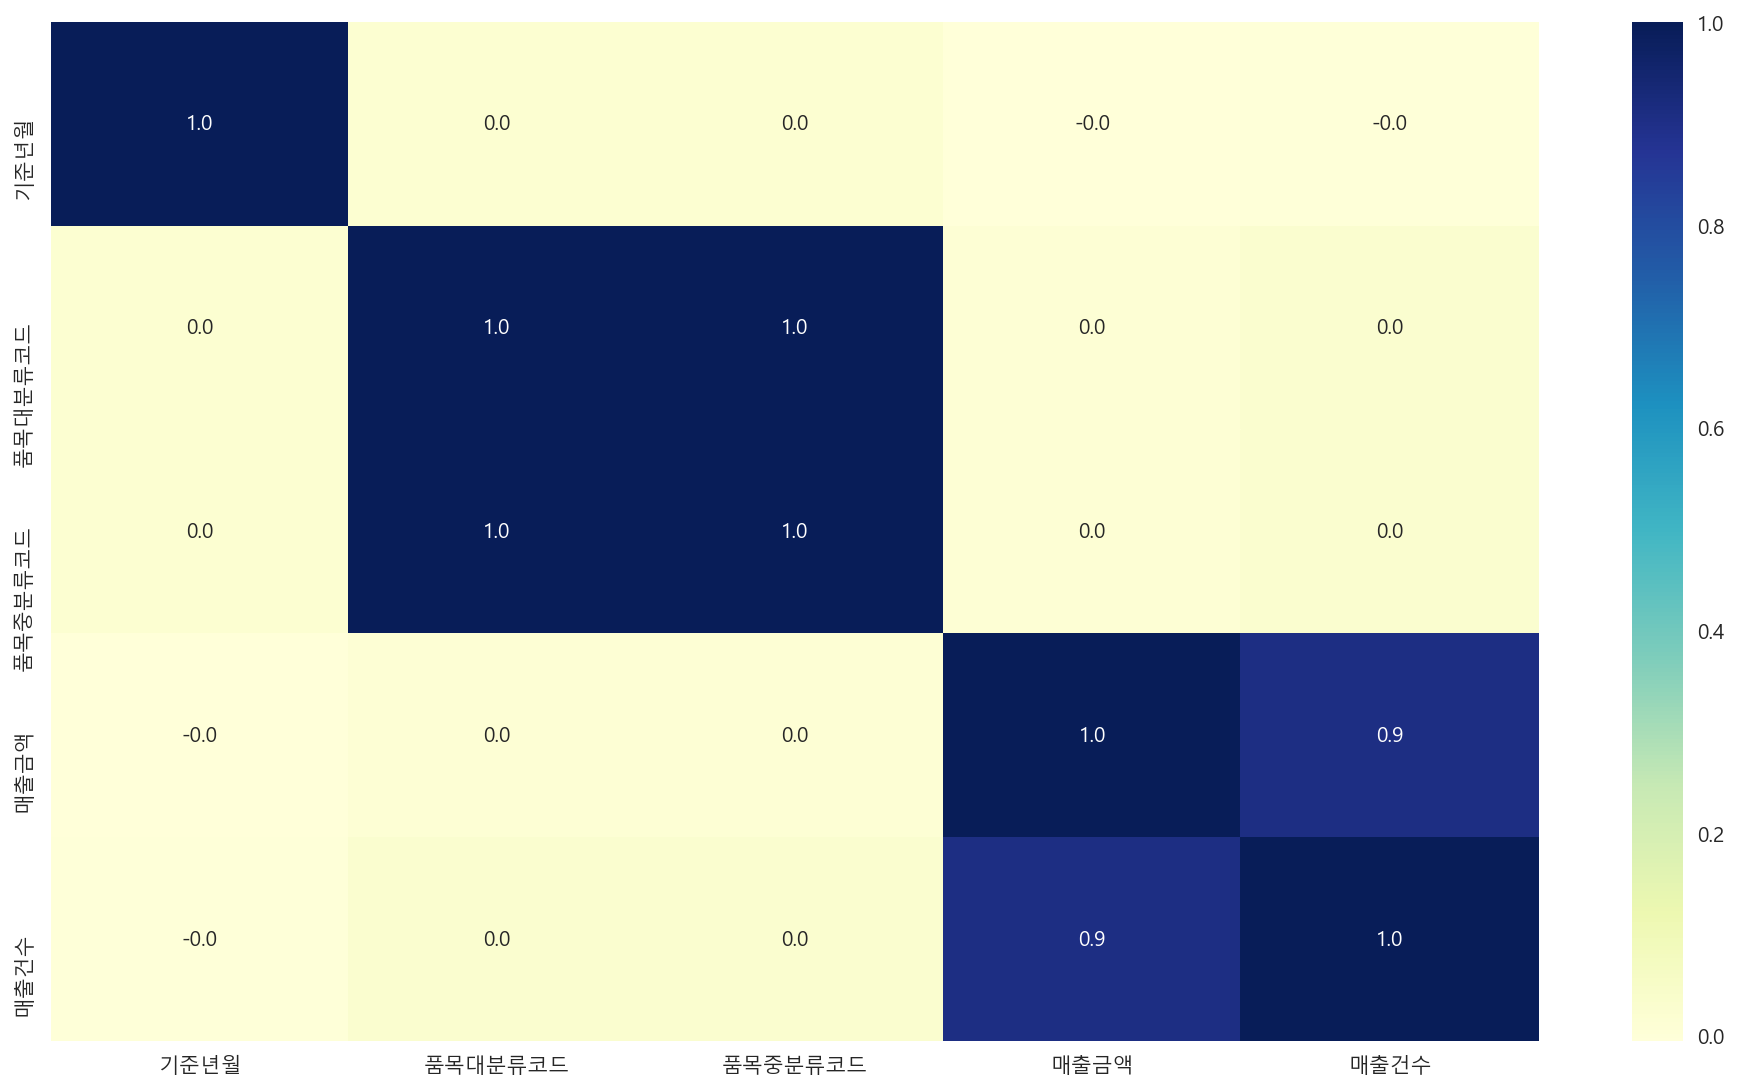

In [3]:
# 3. 상관관계 확인

plt.figure(figsize=(16,9))
sns.heatmap(bc.corr(),cmap='YlGnBu',annot=True,fmt="0.1f")
plt.show()


In [4]:
# 3-2. 결측치 확인
bc.isnull().sum()

기준년월          0
품목대분류코드       0
품목대분류명        0
품목중분류코드       0
품목중분류명        0
성별            0
연령            0
가구생애주기        0
고객소재지_광역시도    0
고객소재지_시군구     0
고객소재지_읍면동     0
매출금액          0
매출건수          0
dtype: int64

In [5]:
# 4. 데이터 전처리

# 4-1. 필요없는 컬럼 제거 + 명목형 변수 바꾸기 힘든 컬럼도 제거
bc.drop(['고객소재지_광역시도','고객소재지_시군구','고객소재지_읍면동'],axis=1,inplace=True)
bc.drop(['품목대분류명','품목중분류명'],axis=1,inplace=True)

# 4-2. 파생변수 추가
# 연령 컬럼 1,2,3,4,5,6
bc['연령'].unique() # array(['40대', '20대', '30대', '50대', '60대 이상', '20세 미만'], dtype=object)

def age(x):
    if x == '20세 미만':
        return x.replace(x,'1')
    elif x == '20대':
        return x.replace(x,'2')
    elif x == '30대':
        return x.replace(x,'3')
    elif x == '40대':
        return x.replace(x,'4')
    elif x == '50대':
        return x.replace(x,'5')
    else:
        return x.replace(x,'6')

bc['연령'] = bc['연령'].apply(age)
bc['연령'] = bc['연령'].astype('int64')


# 성별 컬럼 여 1, 남 0
bc['성별'] = bc['성별'].apply(lambda x:1 if x=='여성' else 0)

# 파생변수 추가 매출평균
pd.options.display.float_format = '{:,.0f}'.format
bc['매출평균'] = bc['매출금액']/bc['매출건수']

# mz세대 -> 연령(1,2,3) -> 1, 나머지 0
bc['mz세대'] = bc['연령'].apply(lambda x:1 if x in (1,2,3) else 0)

In [6]:
bc.drop(['연령'],axis=1,inplace=True)

In [7]:
# 의사결정트리

# 5. 명목형 변수 더미화 (가구생애주기 컬럼만을 더미화)
x = pd.get_dummies(bc.iloc[ : , 0:-1 ])
y = bc.iloc[ : , -1 ]


# 6. 훈련 데이터와 테스트 데이터를 분리 합니다. + 정규화 
from  sklearn.preprocessing  import MinMaxScaler

x_scaled = MinMaxScaler().fit(x).transform(x)

from  sklearn.model_selection  import   train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=0)
print(x_train.shape)  # (415437, 13)
print(x_test.shape)  # (103860, 13)
print(y_train.shape)  # (415437,)
print(y_test.shape) # (103860,)



(415437, 12)
(103860, 12)
(415437,)
(103860,)


In [8]:
# 7. 모델 생성
from  sklearn.tree  import  DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)

In [9]:
# 8.   모델 훈련
model.fit(x_train, y_train)

# 9.   모델 예측
result = model.predict(x_test)

In [10]:
# 10.   모델 평가
print(model.score(x_train,y_train)) # 훈련데이터 스코어 0.9004710702224404
print(model.score(x_test,y_test))  # 테스트 데이터 스코어 0.8997785480454458
print(model.feature_importances_)

0.9004710702224404
0.8997785480454458
[0.00173524 0.01323335 0.0009422  0.         0.00307914 0.00985096
 0.         0.41678607 0.         0.         0.53645469 0.01791835]


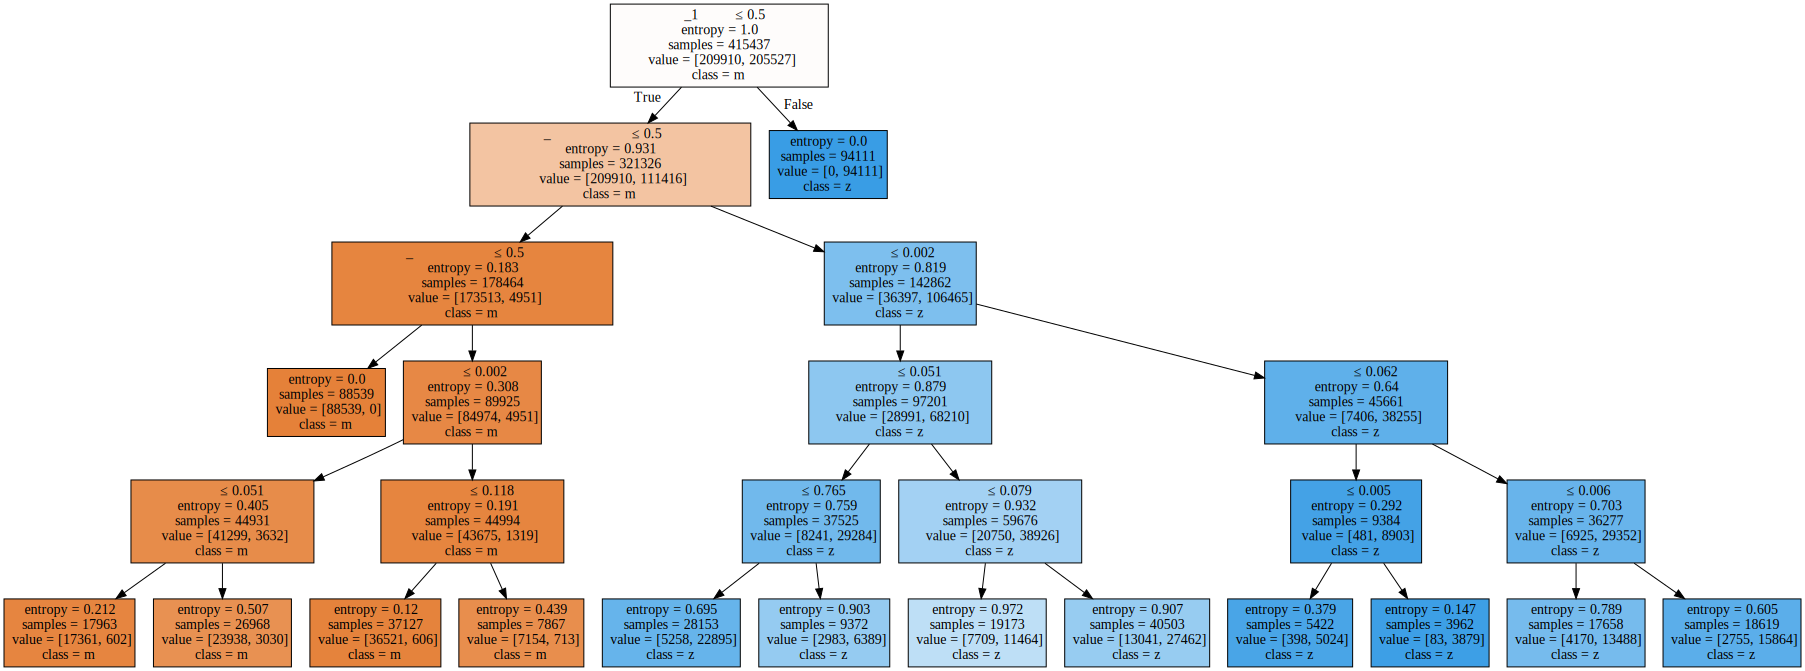

In [11]:
# 11. graphviz 로 의사결정트리 그리기
import graphviz
from sklearn.tree import export_graphviz

export_graphviz(model, out_file="tree.dot", class_names='mz세대',
                feature_names = x.columns, impurity=True, filled=True,special_characters = True)

with open("tree.dot",encoding='utf-8') as f:
  dot_graph = f.read()
graphviz.Source(dot_graph)

import pydotplus
pydot_graph = pydotplus.graph_from_dot_data(dot_graph)
#pydot_graph.set_size('"10,9!"')
pydot_graph.write_png('resized_tree.png')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

위에꺼까지가 bc카드 생데이터로 mz세대 구분하는데 중요한 컬럼 가구생애주기 1인가구인것 알아낸것

아래서부터는 mz 세대의 경우만을 데이터프레임으로 구성해서 1인가구 유무, 초중고자녀가구 유무, 신혼영유아가구 유무 파생변수 추가
정답라벨은 분석결과 토대로 건강식품,신선/요리재료,가공식품,음료컬럼 유무로 파생변수 만들어서 증명할것

In [12]:
# mz 세대만을 가지고 의사결정트리 돌리기
bc_mz = bc[bc['mz세대']==1]
bc_mz.drop(['mz세대'],axis=1,inplace=True)

In [13]:
# 품목중분류코드 <- 정답컬럼이기때문에 품목대분류코드에만 종속될 수 있으므로 컬럼 삭제
bc_mz.drop(['품목대분류코드'],axis=1,inplace=True)


In [14]:
bc_mz['추천상품'] = bc_mz['품목중분류코드'].apply(lambda x:1 if x in (1610,1810,1611,1612) else 0)

In [15]:
# 품목중분류코드 컬럼도 삭제해주기 (아니면 정답라벨의 분류에 완전종속됨) 
bc_mz.drop(['품목중분류코드'],axis=1,inplace=True)

In [16]:
bc_mz

,기준년월,성별,가구생애주기,매출금액,매출건수,매출평균,추천상품
1,201903,1,신혼영유아가구,963789,29,"33,234",0
2,201903,1,신혼영유아가구,924309,46,"20,094",0
3,201903,1,신혼영유아가구,1089360,54,"20,173",0
4,201903,1,신혼영유아가구,1656740,58,"28,564",0
8,201903,1,1인가구,2429276,17,"142,899",0
...,...,...,...,...,...,...,...
519290,202103,1,1인가구,284949,7,"40,707",0
519291,202103,1,1인가구,332870,5,"66,574",0
519292,202103,1,1인가구,1411368,7,"201,624",0
519293,202103,0,1인가구,1386040,63,"22,001",0


In [18]:
# 의사결정트리2

# 5. 명목형 변수 더미화 (가구생애주기 컬럼만을 더미화)
x2 = pd.get_dummies(bc_mz.iloc[ : , 0:-1 ])
y2 = bc_mz.iloc[ : , -1 ]

# 6. 훈련 데이터와 테스트 데이터를 분리 합니다. + 정규화 
from  sklearn.preprocessing  import MinMaxScaler

x_scaled2 = MinMaxScaler().fit(x2).transform(x2)

from  sklearn.model_selection  import   train_test_split

x_train2, x_test2, y_train2, y_test2 = train_test_split(x_scaled2, y2, test_size=0.2, random_state=0)
print(x_train2.shape)  # (415437, 13)
print(x_test2.shape)  # (103860, 13)
print(y_train2.shape)  # (415437,)
print(y_test2.shape) # (103860,)



(205420, 8)
(51355, 8)
(205420,)
(51355,)


In [19]:
x2

,기준년월,성별,매출금액,매출건수,매출평균,가구생애주기_1인가구,가구생애주기_신혼영유아가구,가구생애주기_초중고자녀가구
1,201903,1,963789,29,"33,234",0,1,0
2,201903,1,924309,46,"20,094",0,1,0
3,201903,1,1089360,54,"20,173",0,1,0
4,201903,1,1656740,58,"28,564",0,1,0
8,201903,1,2429276,17,"142,899",1,0,0
...,...,...,...,...,...,...,...,...
519290,202103,1,284949,7,"40,707",1,0,0
519291,202103,1,332870,5,"66,574",1,0,0
519292,202103,1,1411368,7,"201,624",1,0,0
519293,202103,0,1386040,63,"22,001",1,0,0


In [20]:
y2

1         0
2         0
3         0
4         0
8         0
         ..
519290    0
519291    0
519292    0
519293    0
519294    0
Name: 추천상품, Length: 256775, dtype: int64

In [21]:
# 7. 모델 생성
from  sklearn.tree  import  DecisionTreeClassifier

model2 = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=0)

In [22]:
# 8.   모델 훈련
model2.fit(x_train2, y_train2)

# 9.   모델 예측
result2 = model2.predict(x_test2)

In [24]:
# 10.   모델 평가
print(model2.score(x_train2,y_train2)) # 훈련데이터 스코어 0.9004710702224404
print(model2.score(x_test2,y_test2))  # 테스트 데이터 스코어 0.8997785480454458
print(model2.feature_importances_)

0.8606562165319832
0.8612793301528575
[0.         0.02527023 0.00840068 0.17225158 0.77860248 0.00245442
 0.         0.01302061]


두번째 의사결정트리의 경우 가장 중요한 컬럼이 가구생애주기_1인가구 비중이 나오길 바랬으나, 변화량을 나타내는컬럼이 아니었기 때문에 원하던 결과값을 도출할 수 없었음. -> 가구생애주기 분포 변화추이 분석결과만 추가할것